In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPooling2D, MaxPooling3D, Dropout, LayerNormalization, LeakyReLU, BatchNormalization, LSTM, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
# Run: Local
folder_link = ""

In [3]:
# Run: Darren
folder_link = "/content/drive/My Drive/comp4211/project/"

In [ ]:
# Run: Newt
folder_link = "/content/drive/My Drive/HKUST/COMP 4211/Project/"

In [153]:
os.listdir(f"{folder_link}image_data/adausdt")
# os.listdir('/content/drive/My Drive/HKUST/COMP 4211/Project/image_data/adausdt')

['validation_output.csv',
 'validation_data.dat',
 'training_output.csv',
 'training_data.dat',
 'testing_output.csv',
 'testing_data.dat',
 'adausdt_btcusdt_training_images.npz',
 'adausdt_btcusdt_testing_images.npz',
 'adausdt_btcusdt_validation_images.npz']

### Load Data

In [4]:
# train_data = np.load(f"{folder_link}image_data/train_data.npz")["arr_0"]
# train_output = pd.read_csv(f"{folder_link}image_data/train_output.csv")
# test_data = np.load(f"{folder_link}image_data/test_data.npz")["arr_0"]
# test_output = pd.read_csv(f"{folder_link}image_data/test_output.csv")

In [245]:
# train_data = []
# test_data = []
# for coin in coins:
#     train_data.append(np.concatenate([np.load(f"{folder_link}image_data/merge/{coin}usdt_btcusdt_training_images.npz")["images"],
#                                       np.load(f"{folder_link}image_data/merge/{coin}usdt_btcusdt_validation_images.npz")["images"]]))

#     test_data.append(np.load(f"{folder_link}image_data/merge/{coin}usdt_btcusdt_testing_images.npz")["images"])

# train_data = np.array(train_data) #.reshape(-1, 2, 54, 72)
# test_data = np.array(test_data)

# np.savez_compressed(f"{folder_link}image_data/merge_processed/train_data.npz", images = train_data)
# np.savez_compressed(f"{folder_link}image_data/merge_processed/test_data.npz", images = test_data)

In [4]:
coins = ['doge', 'dot', 'eth', 'sol'] + ['ltc', 'bnb', 'trx', 'xlm', 'uni']

train_data = np.load(f"{folder_link}image_data/merge_processed/train_data.npz")["images"]
test_data = np.load(f"{folder_link}image_data/merge_processed/test_data.npz")["images"]
train_data = np.concatenate(train_data, axis=0)
test_data = np.concatenate(test_data, axis=0)

train_output = []
test_output = []
for coin in coins:
    train_output.append(pd.concat([pd.read_csv(f"{folder_link}image_data/{coin}usdt/training_output.csv"),
                                   pd.read_csv(f"{folder_link}image_data/{coin}usdt/validation_output.csv")]))

    test_output.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/testing_output.csv"))

for i in range(len(train_output)):
    train_output[i] = train_output[i].reset_index().drop(columns=["index"])
    # train_output[i].drop(columns=["High", "Low", "Volume", "Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume"], inplace=True)
    test_output[i] = test_output[i].reset_index().drop(columns=["index"])
    # test_output[i].drop(columns=["High", "Low", "Volume", "Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume"], inplace=True)

def normalize(df):
    df["Max24"] = df["High"].shift(1).rolling(window = 24).max()
    df["Max24"] = df["Max24"].fillna(df.loc[24, "Max24"])
    df["Min24"] = df["Low"].shift(1).rolling(window = 24).min()
    df["Min24"] = df["Min24"].fillna(df.loc[24, "Min24"])
    df["Scale"] = np.log(df["Max24"]) - np.log(df["Min24"])
    df["NormalizedLR"] = df["LogReturns"] / df["Scale"]
    df = df.drop(columns=["Volume", "Close time", "Quote asset volume", 'Number of trades', "Taker buy base asset volume", "Taker buy quote asset volume",
                          "High", "Low", "Max24", "Min24", "Scale"], axis = 1)
    return df

for i in range(len(train_output)):
    train_output[i] = normalize(train_output[i])
for i in range(len(test_output)):
    test_output[i] = normalize(test_output[i])

train_output = pd.concat(train_output)
test_output = pd.concat(test_output)

# train_output = pd.DataFrame(np.concatenate(train_output, axis=0))
# test_output = pd.DataFrame(np.concatenate(test_output, axis=0))
train_output.columns = ["Timestamp", "LogReturns", "NormalizedLR"]
test_output.columns = ["Timestamp", "LogReturns", "NormalizedLR"]

### Data Preprocessing

(255600, 2, 54, 72)
(45999, 2, 54, 72)


Text(0.5, 1.0, 'BTC')

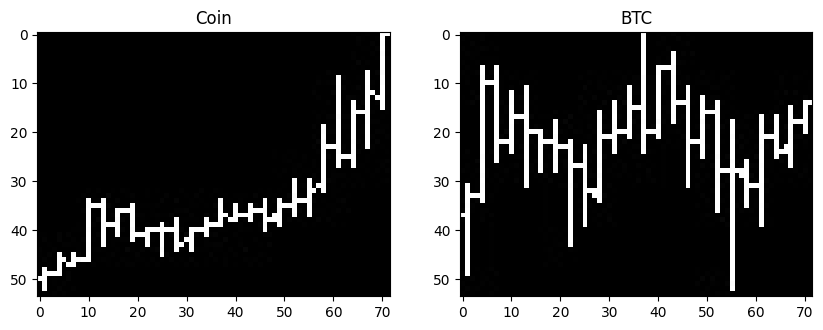

In [12]:
print(train_data.shape)
print(test_data.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_data[0][0], cmap='gray')
axes[0].set_title('Coin')
axes[1].imshow(train_data[0][1], cmap='gray')
axes[1].set_title('BTC')

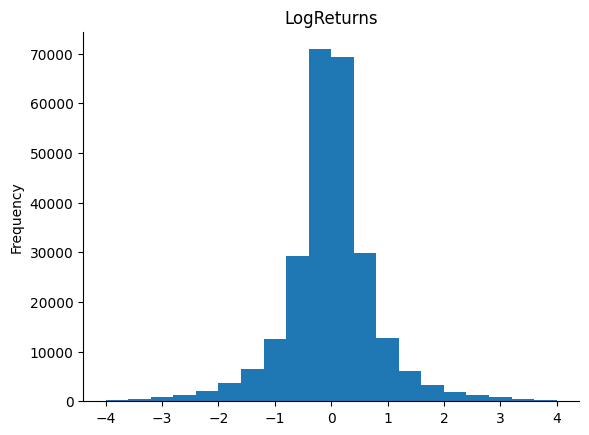

In [15]:
scaler = StandardScaler()
train_output[["LogReturns"]] = scaler.fit_transform(train_output[["LogReturns"]])

train_output['LogReturns'].plot(kind='hist', bins=20, title='LogReturns', range=(-4, 4))
plt.gca().spines[['top', 'right',]].set_visible(False)

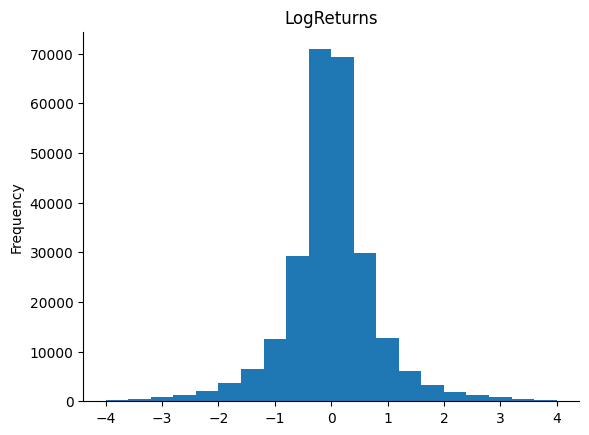

In [7]:
scaler = StandardScaler()
train_output[["NormalizedLR"]] = scaler.fit_transform(train_output[["NormalizedLR"]])

train_output['NormalizedLR'].plot(kind='hist', bins=20, title='NormalizedLR', range=(-4, 4))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
signs = np.sign(train_output["NormalizedLR"]).values
unique, counts = np.unique(signs, return_counts=True)
print(unique, counts)
print(counts[-1] / (counts[0] + counts[-1]))

[-1.  0.  1.] [122497   5837 127266]
0.5095470506039725


### Model Setup

In [ ]:
# class CustomPnlLoss(tf.keras.losses.Loss):
#     def __init__(self, reduction='none', name="custom_pnl_loss"):
#         super().__init__(reduction=reduction, name=name)

#     def call(self, y_true, y_pred):
#         volume = tf.clip_by_value(y_pred, -1, 1)
#         pnl = y_true * volume
#         loss = -tf.reduce_mean(pnl)
#         return loss

#     def get_config(self):
#         config = super().get_config()
#         return config

# class CustomSharpeLoss(tf.keras.losses.Loss):
#     def __init__(self, name="custom_sharpe_loss"):
#         super().__init__(name=name)

#     def call(self, y_true, y_pred):
#         direction = tf.sign(y_pred)
#         volume = tf.clip_by_value(tf.abs(y_pred), 0, 1)

#         pnl = direction * y_true * volume
#         returns = pnl / (tf.reduce_sum(volume) + 1e-10)

#         mean_return = tf.reduce_mean(returns)
#         std_return = tf.math.reduce_std(returns)

#         sharpe_ratio = mean_return / (std_return + 1e-10)
#         loss = -sharpe_ratio

#         return loss

#     def get_config(self):
#         config = super().get_config()
#         return config

In [ ]:
model = Sequential([
    # Layer 1
    Conv3D(64, kernel_size=(1, 5, 5), padding='same', dilation_rate=(1, 3, 1), input_shape=(2, 54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling3D(pool_size=(1, 2, 2)),

    # Layer 2
    Conv3D(128, kernel_size=(1, 5, 5), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling3D(pool_size=(1, 2, 2)),

    # Layer 3
    Conv3D(256, kernel_size=(1, 3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling3D(pool_size=(1, 2, 2)),
    Dropout(0.5),

    # FC and Output
    Flatten(),
    Dense(32),
    Dropout(0.5),
    Dense(1),
])
# custom_loss = CustomPnlLoss()

# model.compile(optimizer='adam', loss=custom_loss)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 2, 54, 72, 64)       │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 54, 72, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 2, 54, 72, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 2, 27, 36, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 2, 27, 36, 128)      │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2, 27, 36, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 2, 27, 36, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 2, 13, 18, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 2, 13, 18, 256)      │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 13, 18, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 2, 13, 18, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 6, 9, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 6, 9, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         884,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,388,353 (5.30 MB)

 Trainable params: 1,387,457 (5.29 MB)

 Non-trainable params: 896 (3.50 KB)

### Regression

In [ ]:
X = train_data.reshape((-1, 2, 54, 72, 1)).astype(int)
y = train_output["NormalizedLR"].values
# y = train_output["LogReturns"].values
# y = to_categorical(np.where(y < 0, 0, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=10, validation_split=0.2, shuffle=True, callbacks=[early_stopping], batch_size=16)

model.save('model.h5')
model = keras.models.load_model('model.h5')
# model = keras.models.load_model('model.h5', custom_objects={'CustomPnlLoss': CustomPnlLoss})

In [18]:
model = keras.models.load_model('model.h5')
# loaded_model = keras.models.load_model('model.h5', custom_objects={'CustomPnlLoss': CustomPnlLoss})

In [8]:
X_test = test_data.reshape((-1, 2, 54, 72, 1))
y_test = test_output["NormalizedLR"]

y_pred = model.predict(X_test).reshape(-1)
norm = y_pred/np.std(y_pred)

print(f"MSE: {np.mean((y_test-norm)**2)}")
print(f"Var: {np.mean((y_test)**2)}")

1438/1438 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
MSE: 68.07381584136053
Var: 0.0225885032560979


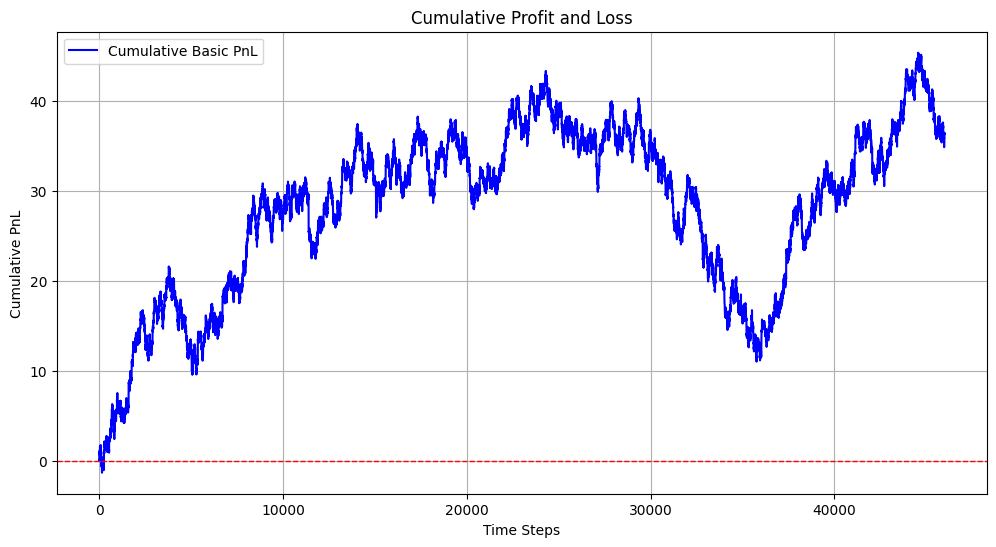

In [9]:
scaling_factor = np.mean(np.abs(y_pred))
pnl = np.array([])
for guess, change in zip(y_pred, test_output["NormalizedLR"].values):
    pnl = np.append(pnl, guess * change / scaling_factor)
cumulative_pnl = np.cumsum(pnl)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl, label='Cumulative Basic PnL', color='blue')
plt.title('Cumulative Profit and Loss')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.show()

In [10]:
# Sharpe Ratios
print("Sharpe: ", pnl.mean() / pnl.std() * np.sqrt(24 * 365))

Sharpe:  0.47825821406844105


### Classification

In [ ]:
X = train_data.reshape((-1, 2, 54, 72, 1)).astype(int)
# y = train_output["NormalizedLR"].values
y = train_output["LogReturns"].values
y = to_categorical(np.where(y < 0, 0, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=10, validation_split=0.2, shuffle=True, callbacks=[early_stopping], batch_size=16)

model.save('model.h5')
model = keras.models.load_model('model.h5')
# model = keras.models.load_model('model.h5', custom_objects={'CustomPnlLoss': CustomPnlLoss})

In [22]:
X_test = test_data.reshape((-1, 2, 54, 72, 1))
y_test = np.where(test_output["NormalizedLR"] > 0, 1, -1)

y_pred = model.predict(X_test)
y_pred_pos = y_pred[:, 0] - y_pred[:, 1]
y_pred_dir = np.sign(y_pred_pos)

accuracy = np.mean(y_pred_dir == y_test)
print(f"Accuracy: {accuracy:.4f}")

1438/1438 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Accuracy: 0.4944


In [429]:
values, counts = np.unique(y_pred_dir, return_counts=True)
print(values, counts)

[-1.  1.] [22629 23370]


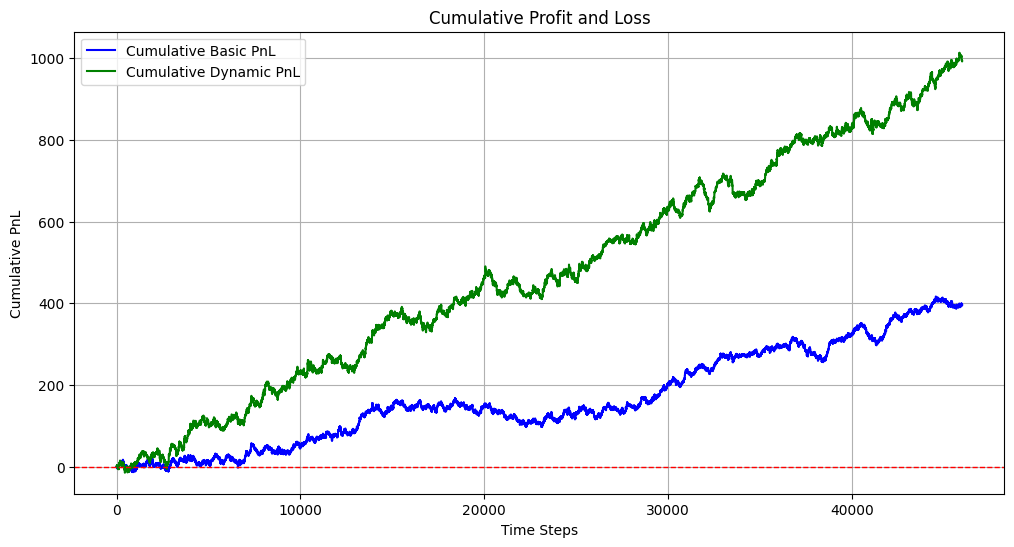

In [38]:
basic_pnl = np.array([])
for guess, change in zip(y_pred_dir, test_output["NormalizedLR"].values):
    basic_pnl = np.append(basic_pnl, guess * change * 5)
cumulative_basic_pnl = np.cumsum(basic_pnl)

scaling_factor = np.mean(np.abs(y_pred_pos**3))
dynamic_pnl = np.array([])
for guess, change in zip(y_pred_pos, test_output["NormalizedLR"].values):
    dynamic_pnl = np.append(dynamic_pnl, guess**3 * change / scaling_factor * 5)
cumulative_dynamic_pnl = np.cumsum(dynamic_pnl)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_basic_pnl, label='Cumulative Basic PnL', color='blue')
plt.plot(cumulative_dynamic_pnl, label='Cumulative Dynamic PnL', color='green')
plt.title('Cumulative Profit and Loss')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.show()

In [39]:
# Sharpe Ratios
print("Basic Strategy Sharpe:  ", basic_pnl.mean() / basic_pnl.std() * np.sqrt(24 * 365))
print("Dynamic Strategy Sharpe:", dynamic_pnl.mean() / dynamic_pnl.std() * np.sqrt(24 * 365))

Basic Strategy Sharpe:   1.0700345447480293
Dynamic Strategy Sharpe: 1.8124091922111378
